<a href="https://colab.research.google.com/github/Vhernan123/Notebook-Trabajo-Final-Master/blob/main/analisis_variable_modelo_crimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
ruta = "/content/drive/MyDrive/colabs_tfm/grilla_sector_id.csv"
base_modelo = pd.read_csv(ruta)
base_modelo.drop("Unnamed: 0", axis=1, inplace=True)

regresion

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# --------- preparar grilla ---------
dfm = base_modelo.copy()
dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])

# target: delitos del día siguiente
dfm["y_reg"] = dfm.groupby("sector_id")["delitos_total"].shift(-1)
dfm = dfm.dropna(subset=["y_reg"]).copy()

# features (las que quieras evaluar)
features = [
    "edad_media", "prop_mujer",
    "delitos_total_lag1","delitos_con_arma_lag1",
    "delitos_total_lag2","delitos_con_arma_lag2",
    "delitos_total_lag3","delitos_con_arma_lag3",
    "delitos_total_lag4","delitos_con_arma_lag4",
    "delitos_total_lag5","delitos_con_arma_lag5",
    "delitos_total_lag6","delitos_con_arma_lag6",
    "delitos_total_lag7","delitos_con_arma_lag7",
    "anio","mes","dia_semana","es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# split temporal (SOLO train para selección de variables → no fugas)
fechas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas)*0.8)
fecha_corte = fechas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]


#Análisis de correlación con el target (y_reg)--se hace en el train

Correlación con y_reg:
 delitos_total_lag1       0.433968
delitos_total_lag6       0.408559
delitos_total_lag2       0.398197
delitos_total_lag5       0.392261
delitos_total_lag7       0.390166
delitos_total_lag4       0.388186
delitos_total_lag3       0.386296
delitos_con_arma_lag6    0.350061
delitos_con_arma_lag5    0.348086
delitos_con_arma_lag1    0.347876
delitos_con_arma_lag4    0.347201
delitos_con_arma_lag2    0.336466
delitos_con_arma_lag7    0.336383
delitos_con_arma_lag3    0.332592
anio                     0.119010
prop_mujer               0.057527
mes                      0.037895
dia_semana               0.018177
es_fin_semana           -0.034873
edad_media              -0.137753
Name: y_reg, dtype: float64


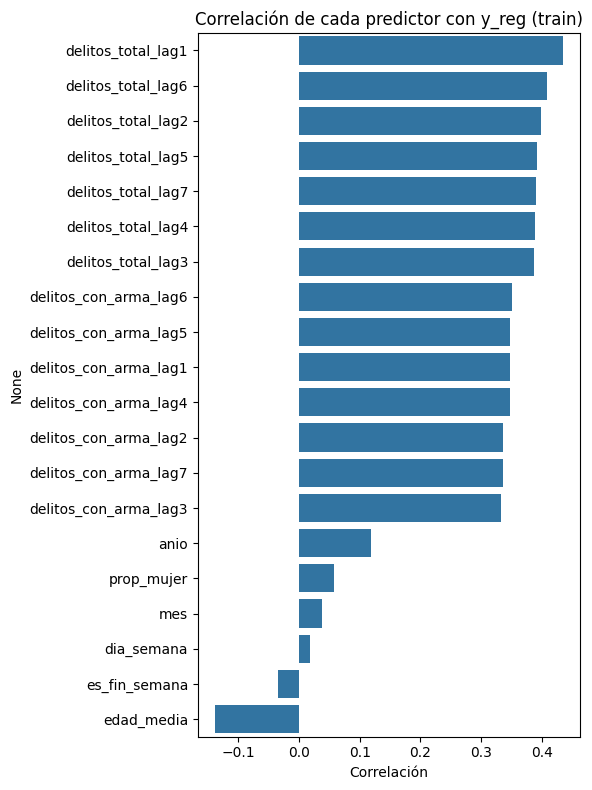

In [ ]:
corrs = pd.concat(
    [X_train, y_train.rename("y_reg")],
    axis=1
).corr()["y_reg"].drop("y_reg").sort_values(ascending=False)

print("Correlación con y_reg:\n", corrs)

plt.figure(figsize=(6,8))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Correlación de cada predictor con y_reg (train)")
plt.xlabel("Correlación")
plt.tight_layout()
plt.show()


# Random Forest preliminar para importancia global


Importancia RF preliminar:
 delitos_total_lag1       0.187801
delitos_total_lag6       0.124183
prop_mujer               0.069105
delitos_total_lag2       0.065668
delitos_total_lag7       0.058231
delitos_total_lag4       0.058097
delitos_total_lag5       0.054986
delitos_total_lag3       0.050224
edad_media               0.047856
delitos_con_arma_lag2    0.044454
delitos_con_arma_lag5    0.038777
delitos_con_arma_lag3    0.032730
delitos_con_arma_lag4    0.030070
delitos_con_arma_lag1    0.027203
delitos_con_arma_lag6    0.026870
delitos_con_arma_lag7    0.026562
mes                      0.022500
dia_semana               0.016571
anio                     0.015584
es_fin_semana            0.002527
Name: rf_importancia, dtype: float64


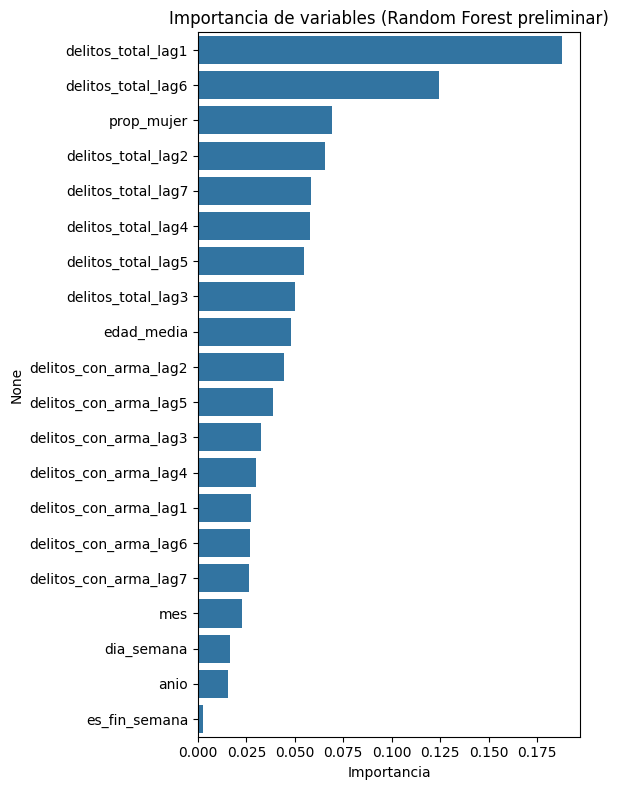

In [ ]:
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
            n_estimators=300,
            max_depth=15,   # moderado, no extremo
            random_state=42,
            n_jobs=-1
        ))
])

pipe_rf.fit(X_train, y_train)

rf_model = pipe_rf.named_steps["rf"]

rf_importances = pd.Series(
    rf_model.feature_importances_,
    index=features,
    name="rf_importancia"
).sort_values(ascending=False)

print("\nImportancia RF preliminar:\n", rf_importances)

plt.figure(figsize=(6,8))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Importancia de variables (Random Forest preliminar)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


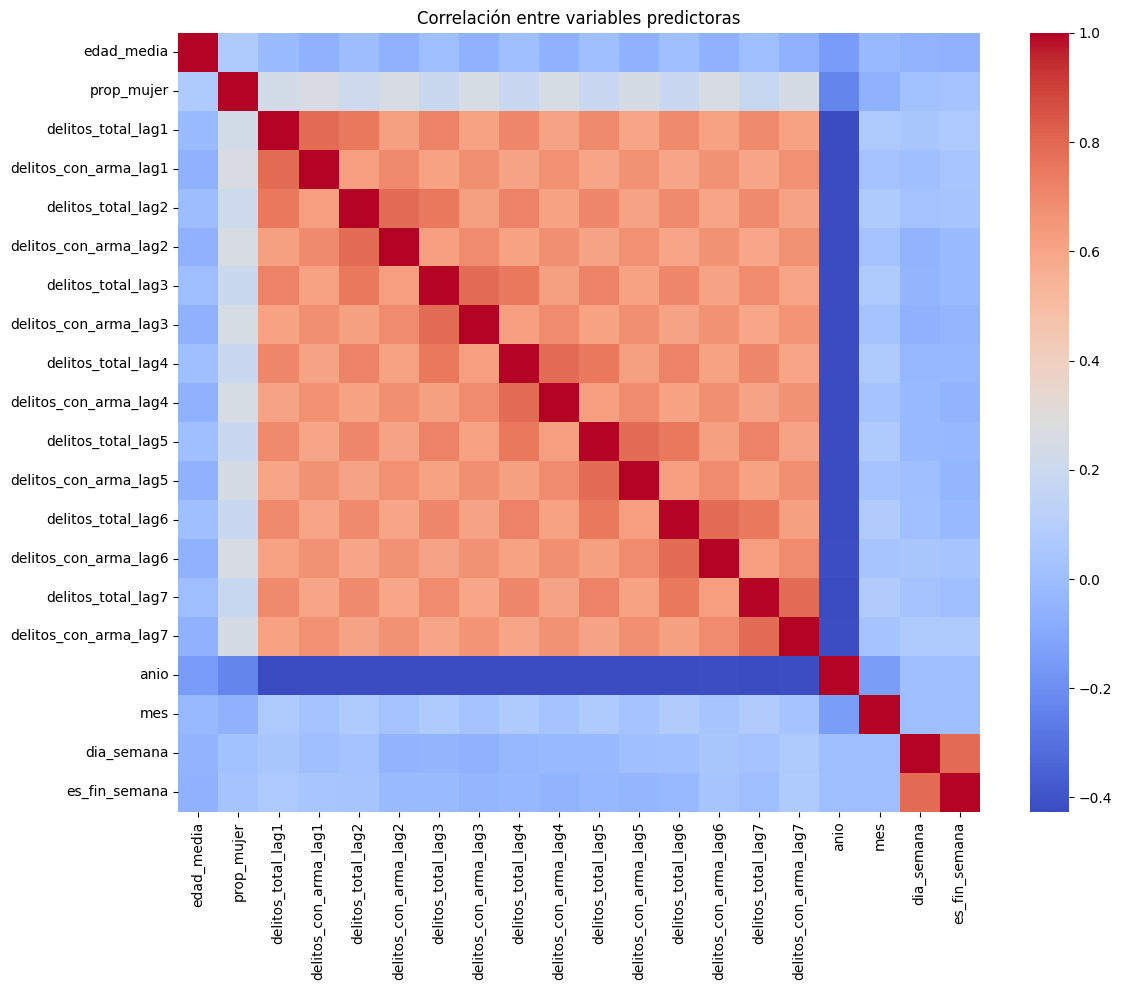

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(dfm[features].corr(), cmap="coolwarm", annot=False)
plt.title("Correlación entre variables predictoras")
plt.tight_layout()
plt.show()
